## This notebook uses the Keras and Tensorflow backends to build a model that predicts the emotion of a user based on text

In [0]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2019-06-24 13:10:46--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2019-06-24 13:10:46--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2019-06-24 13:10:46--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [0]:
!wget https://github.com/tlkh/text-emotion-classification/raw/master/data.csv

--2019-06-24 13:11:19--  https://github.com/tlkh/text-emotion-classification/raw/master/data.csv
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tlkh/text-emotion-classification/master/data.csv [following]
--2019-06-24 13:11:19--  https://raw.githubusercontent.com/tlkh/text-emotion-classification/master/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3354507 (3.2M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   3.20M  --.-KB/s    in 0.08s   

2019-06-24 13:11:20 (38.1 MB/s) - ‘data.csv’ saved [3354507/3354507]



In [0]:
!mkdir dataset
!mkdir dataset/glove

In [0]:
!unzip glove.twitter.27B.zip -d dataset/glove

Archive:  glove.twitter.27B.zip
  inflating: dataset/glove/glove.twitter.27B.25d.txt  
  inflating: dataset/glove/glove.twitter.27B.50d.txt  
  inflating: dataset/glove/glove.twitter.27B.100d.txt  
  inflating: dataset/glove/glove.twitter.27B.200d.txt  


In [0]:
ls -lah dataset/glove

total 3.6G
drwxr-xr-x 2 root root 4.0K Jun 24 13:11 ./
drwxr-xr-x 3 root root 4.0K Jun 24 13:11 ../
-rw-rw-r-- 1 root root 975M Aug 14  2014 glove.twitter.27B.100d.txt
-rw-rw-r-- 1 root root 2.0G Aug 14  2014 glove.twitter.27B.200d.txt
-r--r--r-- 1 root root 246M Aug 14  2014 glove.twitter.27B.25d.txt
-rw-rw-r-- 1 root root 488M Aug 14  2014 glove.twitter.27B.50d.txt


#Set Up 

In [0]:
MAX_NB_WORDS = 40000 # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 30 # max length of text (words) including padding
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 200 # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "dataset/glove/glove.twitter.27B."+str(200)+"d.txt"
print("Loaded Parameters:\n",
      MAX_NB_WORDS,MAX_SEQUENCE_LENGTH+5,
      VALIDATION_SPLIT,EMBEDDING_DIM,"\n",
      GLOVE_DIR)

[i] Loaded Parameters:
 40000 35 0.2 200 
 dataset/glove/glove.twitter.27B.200d.txt


In [0]:
print("Importing Modules")
import numpy as np
import pandas as pd
import re, sys, os, csv, keras, pickle
from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding, Add, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
print("Using Keras version",keras.__version__)

Importing Modules


Using TensorFlow backend.


Using Keras version 2.2.4


In [0]:
texts, labels = [], []
print("Reading from csv file...", end="")
with open('data.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        texts.append(row[0])
        labels.append(row[1])
print("Done!")

Reading from csv file...Done!


In [0]:
#Convert text to word tokens (numbers that refer to the words)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Saved word tokenizer to file: tokenizer.pickle")

Saved word tokenizer to file: tokenizer.pickle


In [0]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data_int = pad_sequences(sequences, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data = pad_sequences(data_int, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))

Found 34359 unique tokens.


In [0]:
labels = to_categorical(np.asarray(labels)) # convert to one-hot encoding vectors
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (47288, 30)
Shape of label tensor: (47288, 5)


In [0]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [0]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Number of entries in each category:')
print("Training:\n",y_train.sum(axis=0))
print("Validation:\n",y_val.sum(axis=0))

Number of entries in each category:
Training:
 [ 7671. 13020. 12792.  3464.   884.]
Validation:
 [1972. 3277. 3146.  837.  225.]


Preparing the Embedding layer
Compute an index mapping words to known embeddings, by parsing the data dump of pre-trained embeddings.

We use pre-trained GloVe vectors from Stanford NLP. For new words, a "randomised vector" will be created.

In [0]:
embeddings_index = {}
f = open(GLOVE_DIR)
print("Loading GloVe from:",GLOVE_DIR,"...",end="")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\nProceeding with Embedding Matrix...", end="")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print("Completed")

Loading GloVe from: dataset/glove/glove.twitter.27B.200d.txt ...Done.
Proceeding with Embedding Matrix...Completed


In [0]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [0]:
def initial_boost(epoch):
    if epoch==0: return float(8.0)
    elif epoch==1: return float(4.0)
    elif epoch==2: return float(2.0)
    elif epoch==3: return float(1.5)
    else: return float(1.0)

In [0]:
def step_cyclic(epoch):
    try:
        l_r, decay = 1.0, 0.0001
        if epoch%33==0:multiplier = 10
        else:multiplier = 1
        rate = float(multiplier * l_r * 1/(1 + decay * epoch))
        #print("Epoch",epoch+1,"- learning_rate",rate)
        return rate
    except Exception as e:
        print("Error in lr_schedule:",str(e))
        return float(1.0)

In [0]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector
print("Completed!")

Completed!


In [0]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

W0624 13:13:37.120589 139728279537536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 13:13:37.188617 139728279537536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 13:13:37.210124 139728279537536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 13:13:37.231815 139728279537536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0624 13:13:37.237188 1397282795

In [0]:
l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

W0624 13:13:41.336377 139728279537536 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_8 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

In [0]:
l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.3)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_train)
l_conv_4t = Dropout(0.3)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_frozen)
l_conv_3f = Dropout(0.3)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_train)
l_conv_3t = Dropout(0.3)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.3)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.3)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(l_merge_2)

In [0]:
l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(4)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(5, activation='softmax')(l_dense)

W0624 13:13:44.318290 139728279537536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [0]:
model = Model(sequence_input, preds)
adadelta = optimizers.Adadelta(lr=0.9, rho=0.95, epsilon=None, decay=0.002)
lr_metric = get_lr_metric(adadelta)
model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])

W0624 13:13:44.427729 139728279537536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
model_checkpoints = callbacks.ModelCheckpoint("checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=0)
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [0]:
model.summary()
model.save('Model1.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 12)       9936        embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectio

In [0]:
model = keras.models.load_model("Model1.h5")

In [0]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=30, batch_size=128,
          callbacks=[tensorboard, model_checkpoints])

pd.DataFrame(model_log.history).to_csv("history.csv")

Training Progress:
Train on 37831 samples, validate on 9457 samples
Epoch 1/30
37831/37831 [==============================] - 260s 7ms/step - loss: 0.8660 - acc: 0.6492 - val_loss: 0.9241 - val_acc: 0.6218

Epoch 00001: val_loss did not improve from 0.92347
Epoch 2/30
37831/37831 [==============================] - 254s 7ms/step - loss: 0.8631 - acc: 0.6493 - val_loss: 0.9239 - val_acc: 0.6223

Epoch 00002: val_loss did not improve from 0.92347
Epoch 3/30
37831/37831 [==============================] - 251s 7ms/step - loss: 0.8638 - acc: 0.6498 - val_loss: 0.9232 - val_acc: 0.6230

Epoch 00003: val_loss improved from 0.92347 to 0.92318, saving model to checkpoint-0.923.h5
Epoch 4/30
37831/37831 [==============================] - 252s 7ms/step - loss: 0.8610 - acc: 0.6515 - val_loss: 0.9244 - val_acc: 0.6242

Epoch 00004: val_loss did not improve from 0.92318
Epoch 5/30
37831/37831 [==============================] - 248s 7ms/step - loss: 0.8616 - acc: 0.6514 - val_loss: 0.9237 - val_acc: 

### Copy checkpoint weights to Google Drive

In [0]:
cp checkpoint-0.923.h5 drive/My\ Drive/

In [0]:
x_train.shape

(37831, 30)

In [0]:
y_train.shape

(37831, 5)

Testing and Evaluation

In [0]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

classes = ["indifferent", "happy", "sad", "hateful","angry"]

In [0]:
model_test = load_model('checkpoint-0.923.h5')
Y_test = np.argmax(y_val, axis=1) 
y_pred = model_test.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

In [0]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

 indifferent       0.49      0.37      0.42      1972
       happy       0.64      0.71      0.67      3277
         sad       0.61      0.68      0.64      3146
     hateful       0.85      0.65      0.74       837
       angry       0.88      0.68      0.77       225

    accuracy                           0.62      9457
   macro avg       0.69      0.62      0.65      9457
weighted avg       0.62      0.62      0.62      9457



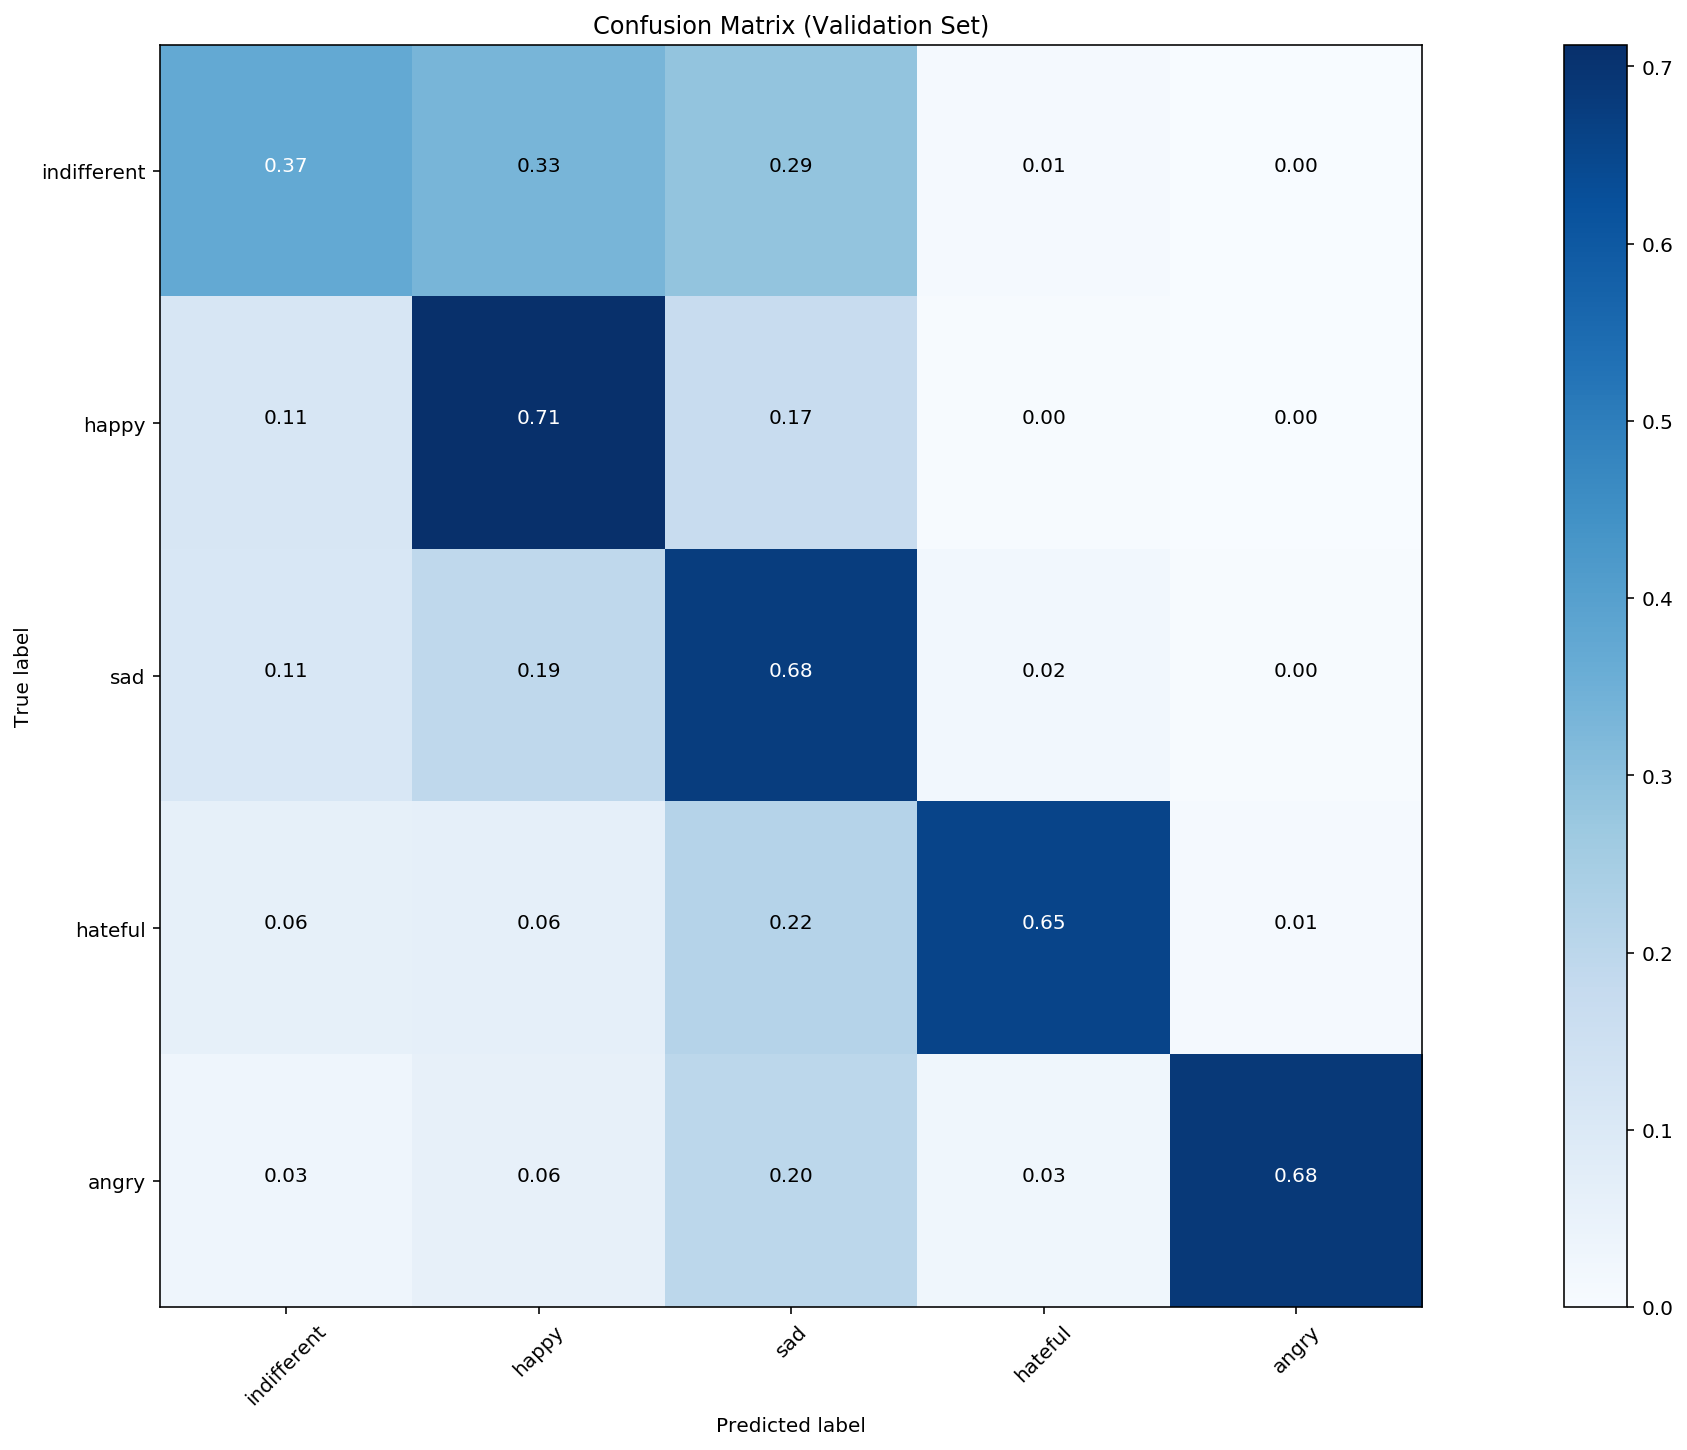

In [0]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)

Pull Test Data

In [0]:
import tweepy
key = ''
secret = ''
auth = tweepy.OAuthHandler(consumer_key = key, consumer_secret = secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [0]:
tweets = ["I salute you for the bravery and sacrifice! A true hero indeed.",
        "I am sorry but I trust HRW I damned sight more than the PAP and it's cronies! Off course the PAP will say that they (HRW) made things up...despite of the fact that SG is a dictator state!?",
        "PAP are taking the piss again!",
        "Thought he sold his kidney to buy it; Instead, he bought a kidney then bought the car Filthy rich This is why we need communism",
        "Somebody needs to water Tharman's head, hair needs to be grown there",
        "what a nuisance fk. a proper clean and flat footpath,,now obstructed by sharedbikes..! which idiotic MP allowed this to happen?",
        "What baby bonus scheme ??? To grow up a kid in Singapore you think is easy now bo ??? Both parent need to work to grow up a kid until 21 , you think tats easy bo ??? Think la"
       ]

In [0]:
sequences_test = tokenizer.texts_to_sequences(tweets)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
for n, prediction in enumerate(y_prob):
    pred = y_prob.argmax(axis=-1)[n]
    print(text[n],"\nPrediction:",classes[pred],"\n")

I salute you for the bravery and sacrifice! A true hero indeed. 
Prediction: happy 

I am sorry but I trust HRW I damned sight more than the PAP and it's cronies! Off course the PAP will say that they (HRW) made things up...despite of the fact that SG is a dictator state!? 
Prediction: sad 

PAP are taking the piss again! 
Prediction: indifferent 

Thought he sold his kidney to buy it; Instead, he bought a kidney then bought the car Filthy rich This is why we need communism 
Prediction: hateful 

Somebody needs to water Tharman's head, hair needs to be grown there 
Prediction: sad 

what a nuisance fk. a proper clean and flat footpath,,now obstructed by sharedbikes..! which idiotic MP allowed this to happen? 
Prediction: hateful 

What baby bonus scheme ??? To grow up a kid in Singapore you think is easy now bo ??? Both parent need to work to grow up a kid until 21 , you think tats easy bo ??? Think la 
Prediction: sad 

